<a href="https://colab.research.google.com/github/appleBattery/Eye-based-Verification/blob/master/Train_classifier_on_MMU2_and_IITD_ver_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries and dependencies:

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from math import ceil
import torchvision.models as models
from torchvision import transforms
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset

### Define Custom Neural network for training (Scheme 2)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # this model was working.
print(device)

class iris_classifier(nn.Module):
  def __init__(self):
    super(iris_classifier, self).__init__()
    # load resNet50
    self.resNet50 = models.resnet50(pretrained=True)

    # Remove final layer
    modules=list(self.resNet50.children())[:-1]
    self.resNet50 = torch.nn.Sequential(*modules)

    # Flatten output from Global Average Pool of ResNet
    self.resNet50.flat = torch.nn.Flatten() 
    
    # freeze all layers of the resNet50
    for param in self.resNet50.parameters():
      param.requires_grad = False 
    
    # Define the fully connected layers as per Scheme 2
    self.fc1 = nn.Linear(2048,128)
    self.fc2 = nn.Linear(256,16)
    self.fc3 = nn.Linear(16,1)

  def forward(self, img1, img2):

    # Extract features from resnet
    self.resNet50.eval()
    out1 = self.resNet50(img1)
    out2 = self.resNet50(img2)
    
    # pass both images through fc1
    out1 = F.relu(self.fc1(out1))
    out2 = F.relu(self.fc1(out2))

    out = torch.cat((out1,out2),1)

    out = F.relu(self.fc2(out))
    out = self.fc3(out)

    return out

classifier = iris_classifier()
classifier = classifier.to(device)
print(classifier)

cuda:0
iris_classifier(
  (resNet50): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

### Define the dataloader classes for iitd dataset and MMU2 dataset.

In [ ]:
# Define image transformations to be applied on the images. Normalized to ensure it matches the distribution of Imagenet.
autobots = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])])

In [5]:
# The dataset must be present in mentioned path in the original directory form. 

class iitd_dataset(Dataset):
  def __init__(self):
    self.path = '/content/drive/My Drive/iris detection/data/IITD/'
  def __len__(self):
    # hard-coded total number of image sets. Ideally this must not be done.
    # There are 2080 (208 subjects (skipped certain subjects) X 10 possible permutations of 5 images)
    # positive image sets for left eye. Same for right eye.
    # And rest are negative sets (picked in a idiosyncratic manner). 
    # Ideally, pick atleast 2-3 times the number of negative images for greater precision.
    return 8320
  
  def get_fldr_idx(self,idx):
    
    idx += 130 # for skipping over first 13 folders
    if (idx >= 261): # skip 27th folder
      idx += 10
    if (idx >= 541): # skip 55th folder
      idx += 10
    if (idx >= 641): # skip 65th folder
      idx += 10

    fldr_idx = (idx//10) + 1
    fldr_idx = fldr_idx if ((idx%10)!=0) else (fldr_idx-1)
    fldr_idx = str(fldr_idx).zfill(3)
    return (fldr_idx,idx)

  def pos_permute(self,count):
    for i in range(1,5):
        for j in range((i+1),6):
          count -= 1
          if count==0:
            return (str(i).zfill(2),str(j).zfill(2))
  
  def neg_permute(self,count,idx1):
    
    permute1 = (count//2) if (count%2)==0 else ((count//2)+1)
    permute2 = count%5 if (count%5)!=0 else 5
    permute1 = str(permute1).zfill(2); permute2 = str(permute2).zfill(2)

    if idx1<214:
      neg_idx = idx1+count
      neg_idx = neg_idx if ((neg_idx!=27)&(neg_idx!=55)&(neg_idx!=65)) else (neg_idx+1) # skip certain folders
      neg_idx = str(neg_idx).zfill(3)
    else:
      neg_idx = idx1-count
      neg_idx = str(neg_idx).zfill(3)
    return (permute1, permute2, neg_idx)

  def __getitem__(self, idx):
    idx += 1 #for zero indexing

    if idx<=2080: # read positive image sets for left eye
      fldr_idx,idx = self.get_fldr_idx(idx)
      count = idx%10
      count = count if (count!=0) else 10
      
      permute1, permute2 = self.pos_permute(count)
      
      img1 = Image.open(self.path+fldr_idx+'/'+permute1+'_L.bmp')
      img2 = Image.open(self.path+fldr_idx+'/'+permute2+'_L.bmp')
      label = 1.

    elif (2081<=idx<=4160): # read negative image sets for right eye
      fldr_idx,idx = self.get_fldr_idx(idx-2080)
      count = idx%10
      count = count if (count!=0) else 10
      
      permute1, permute2 = self.pos_permute(count)
      permute1 = str(int(permute1)+5).zfill(2); permute2 = str(int(permute2)+5).zfill(2)
      
      img1 = Image.open(self.path+fldr_idx+'/'+permute1+'_R.bmp')
      img2 = Image.open(self.path+fldr_idx+'/'+permute2+'_R.bmp')
      label = 1.

    elif (4161<=idx<=6240): # read negative image sets for left eye
      fldr_idx,idx = self.get_fldr_idx(idx-4160)
      count = idx%10
      count = count if (count!=0) else 10

      permute1,permute2,neg_idx = self.neg_permute(count,int(fldr_idx))

      img1 = Image.open(self.path+fldr_idx+'/'+permute1+'_L.bmp')
      img2 = Image.open(self.path+ neg_idx+'/'+permute2+'_L.bmp')
      label = 0.

    else: # read negative image sets for right eye
      fldr_idx,idx = self.get_fldr_idx(idx-6240)
      count = idx%10
      count = count if (count!=0) else 10

      permute1,permute2,neg_idx = self.neg_permute(count,int(fldr_idx))
      permute1 = str(int(permute1)+5).zfill(2); permute2 = str(int(permute2)+5).zfill(2)

      img1 = Image.open(self.path+fldr_idx+'/'+permute1+'_R.bmp')
      img2 = Image.open(self.path+ neg_idx+'/'+permute2+'_R.bmp')
      label = 0.
    
    # It's probably possible to transform and store the images after transformation.
    # Will save some time during training.
    img1 = autobots(img1) 
    img2 = autobots(img2)
    img1 = img1.type(torch.float16)
    img2 = img2.type(torch.float16)
    label = torch.tensor([label],dtype=torch.float16)

    return (img1,img2,label)

iitd = iitd_dataset()

In [6]:
# Load the mmu dataset by index from disk. but note that the 50th image is a bummer because it only got right eye data. 

class mmu2_dataset(Dataset):
  def __init__(self):
    self.path = '/content/drive/My Drive/iris detection/data/MMU 2/'
  def __len__(self):
    return 3980

  def pos_permute(self,count):
    for i in range(1,5):
        for j in range((i+1),6):
          count -= 1
          if count==0:
            return (str(i).zfill(2),str(j).zfill(2))
  
  def neg_permute(self,count,idx1):
    
    permute1 = (count//2) if (count%2)==0 else ((count//2)+1)
    permute2 = count%5 if (count%5)!=0 else 5
    permute1 = str(permute1).zfill(2); permute2 = str(permute2).zfill(2)

    if idx1<90:
      neg_idx = idx1+count
      neg_idx = neg_idx if (neg_idx!=50) else 100
      neg_idx = str(neg_idx).zfill(2) if (neg_idx<10) else str(neg_idx)
    else:
      neg_idx = idx1-count
      neg_idx = neg_idx if (neg_idx!=50) else 100
      neg_idx = str(neg_idx).zfill(2) if (neg_idx<10) else str(neg_idx)
    return (permute1, permute2, neg_idx)

  def get_file_idx(self,idx):
    if idx<=980:
      file_idx1 = (idx//20) + 1
      file_idx1 = file_idx1 if ((idx%20)!=0) else (file_idx1-1)
      file_idx2 = '01' if (((idx%20)<=10)&((idx%20)!=0)) else '02'
      file_idx1 = str(file_idx1).zfill(2) if (file_idx1<10) else str(file_idx1)
    else:
      idx += 10
      file_idx1 = (idx//20) + 1
      file_idx1 = file_idx1 if ((idx%20)!=0) else (file_idx1-1)
      file_idx2 = '01' if (((idx%20)<=10)&((idx%20)!=0)) else '02'
      file_idx1 = str(file_idx1).zfill(2) if (file_idx1<10) else str(file_idx1)
    return (file_idx1,file_idx2,idx)
      
  def __getitem__(self, idx):
    idx+=1

    if idx<=1990: # read positive image sets from disk
      file_idx1,file_idx2,idx = self.get_file_idx(idx)
      count = idx%10
      count = count if (count!=0) else 10
      
      permute1, permute2 = self.pos_permute(count)
      
      img1 = Image.open(self.path+file_idx1+file_idx2+permute1+'.bmp')
      img2 = Image.open(self.path+file_idx1+file_idx2+permute2+'.bmp')
      label = 1.
    else: # read negative image sets from disk
      file_idx1,file_idx2,idx = self.get_file_idx(idx-1990)
      count = idx%10
      count = count if (count!=0) else 10
      
      permute1,permute2,neg_idx = self.neg_permute(count,int(file_idx1))

      img1 = Image.open(self.path+file_idx1+file_idx2+permute1+'.bmp')
      img2 = Image.open(self.path+ neg_idx +file_idx2+permute2+'.bmp')
      label = 0.
      
    img1 = autobots(img1)
    img2 = autobots(img2)
    img1 = img1.type(torch.float16)
    img2 = img2.type(torch.float16)
    label = torch.tensor([label],dtype=torch.float16)

    return (img1,img2,label)

mmu2 = mmu2_dataset()

### combined dataset, split mmu2 dataset

In [7]:
train_size = int(0.7 * len(mmu2))
test_size = len(mmu2) - train_size

# Split the mmu2 dataset into train and validation set
mmu2_train, mmu2_test = torch.utils.data.random_split(mmu2, [train_size, test_size],generator=torch.Generator().manual_seed(2020))

In [8]:
# Create a combined dataset from the two dataloader classes
class combined_dataset(Dataset):
  def __init__(self):
    pass
  def __len__(self):
    return (len(mmu2)+len(iitd))
  def __getitem__(self, idx):
    if idx<len(iitd):
      return iitd[idx]
    else:
      idx = idx - len(iitd)
      return mmu2_train[idx]

combined = combined_dataset()

### Training the network

In [9]:
decay = []; no_decay = []; l2_reg = 4*10**(-5); # weight decay parameter

# To avoid applying weight decay to the resNet50 parameters. 
# Also, decay is not applied to the bias parameters.
for name, param in classifier.named_parameters():
  if param.requires_grad:
    if len(param.shape) == 1 or name.endswith(".bias"): no_decay.append(param)
    else: decay.append(param)

parameters = [{'params': no_decay, 'weight_decay': 0.}, {'params': decay, 'weight_decay': l2_reg}]    

In [10]:
size_batches = 256; no_batches = ceil(len(combined)/size_batches); 

# To enhance specificity (precision)
sensitivity_weight = torch.tensor([0.4]); sensitivity_weight = sensitivity_weight.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=sensitivity_weight)

#Learning rate and step decay
optimizer = optim.SGD(parameters, lr=0.075, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 4, gamma=0.9)

# Define the data loaders
trainloader = torch.utils.data.DataLoader(combined, batch_size=size_batches,shuffle=True, num_workers = 4)
testloader = torch.utils.data.DataLoader(mmu2_test, batch_size=size_batches,shuffle=True, num_workers = 2)
mmu2_trainloader = torch.utils.data.DataLoader(mmu2_train, batch_size=size_batches,shuffle=True, num_workers = 2)

# path to save model
path = '/content/drive/My Drive/iris detection/data/' 

In [11]:
# To compute accuracy on testloader while training
def validation_accuracy():
  acc=0;
  classifier.eval()
  for data in testloader:
    img1, img2, lab = data
    img1 = img1.to(device); img2 = img2.to(device);
    img1 = img1.type(torch.cuda.FloatTensor); img2 = img2.type(torch.cuda.FloatTensor)

    out = classifier(img1,img2)
    out = torch.sigmoid(out.cpu())
    pred = out.detach().numpy()
    lab = lab.numpy()
    pred[pred>=0.5] = 1.
    pred[pred<0.5] = 0.

    acc += np.sum(pred==lab)

  acc = round(acc/(len(mmu2_test)),4)*100
  print('Validation Accuracy: {}'.format(acc))
  print()
  return acc

In [12]:
# To compute accuracy on mmu2_trainloader while training
def mmu2_train_accuracy():
  acc=0;
  classifier.eval()
  for data in mmu2_trainloader:
    img1, img2, lab = data
    img1 = img1.to(device); img2 = img2.to(device);
    img1 = img1.type(torch.cuda.FloatTensor); img2 = img2.type(torch.cuda.FloatTensor)

    out = classifier(img1,img2)
    out = torch.sigmoid(out.cpu())
    pred = out.detach().numpy()
    lab = lab.numpy()
    pred[pred>=0.5] = 1.
    pred[pred<0.5] = 0.
    acc += np.sum(pred==lab)

  acc = round(acc/(len(mmu2_train)),4)*100
  print('MMU2 Training Accuracy: {}'.format(acc))
  print()
  return acc

In [13]:
# To compute accuracy on trainloader while training i.e. whole training data
def train_accuracy():
  acc=0;
  classifier.eval()
  for data in trainloader:
    img1, img2, lab = data
    img1 = img1.to(device); img2 = img2.to(device);
    img1 = img1.type(torch.cuda.FloatTensor); img2 = img2.type(torch.cuda.FloatTensor)

    out = classifier(img1,img2)
    out = torch.sigmoid(out.cpu())
    pred = out.detach().numpy()
    lab = lab.numpy()
    pred[pred>=0.5] = 1.
    pred[pred<0.5] = 0.
    acc += np.sum(pred==lab)

  acc = round(acc/(len(combined)),4)*100
  print('Complete Training Accuracy: {}'.format(acc))
  print()
  return acc

In [14]:
# training code!

#Falaana dhimkana
loss_values = []
mmu2_train_acc = []
train_acc = []
val_acc = []

for epoch in range(100):  # loop over the dataset multiple times, duh
  
  classifier.train()
  print('Epoch {}/{}'.format(epoch+1, 100))
  print('-' * 10)

  running_loss = 0.0
    
  for data in trainloader:
    img1_batch, img2_batch, labels = data
    img1_batch = img1_batch.to(device); img2_batch = img2_batch.to(device); labels = labels.to(device)

    # BCE with logits loss somehow demands it
    img1_batch = img1_batch.type(torch.cuda.FloatTensor); img2_batch = img2_batch.type(torch.cuda.FloatTensor);
    labels = labels.type(torch.cuda.FloatTensor)

    # zero the parameter gradients
    optimizer.zero_grad()
    outputs = classifier(img1_batch,img2_batch)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  scheduler.step()

  # Compute loss every epoch
  epoch_loss = (running_loss/no_batches)
  loss_values.append(epoch_loss)

  print('Loss: {:.4f}'.format(epoch_loss))
  print()

  # Compute and store accuracy every 5 epochs
  if (((epoch+1)%5) == 0):
    
    mmu2_train_acc.append(mmu2_train_accuracy())
    train_acc.append(train_accuracy())
    val_acc.append(validation_accuracy())

    # save the best model once validation accuracy reached 90 percent
    if (val_acc[-1]>=90):
      diff = train_acc[-1] - val_acc[-1]
      index = len(val_acc)-1
      for i in range(len(val_acc)-1):
        if (val_acc[i]>=90)&((train_acc[i] - val_acc[i])<diff):
          index = i
      if (index==(len(val_acc)-1)):
        torch.save(classifier.state_dict(), path+'model3 reg 4e-5.pth')

print('Finished Training')

Epoch 1/100
----------
Loss: 0.4322

Epoch 2/100
----------
Loss: 0.4207

Epoch 3/100
----------
Loss: 0.4187

Epoch 4/100
----------
Loss: 0.4187

Epoch 5/100
----------
Loss: 0.4186

MMU2 Training Accuracy: 50.32

Complete Training Accuracy: 50.080000000000005

Validation Accuracy: 49.25

Epoch 6/100
----------
Loss: 0.4182

Epoch 7/100
----------
Loss: 0.4131

Epoch 8/100
----------
Loss: 0.3765

Epoch 9/100
----------
Loss: 0.2981

Epoch 10/100
----------
Loss: 0.2707

MMU2 Training Accuracy: 68.84

Complete Training Accuracy: 68.73

Validation Accuracy: 68.17

Epoch 11/100
----------
Loss: 0.2629

Epoch 12/100
----------
Loss: 0.2567

Epoch 13/100
----------
Loss: 0.2445

Epoch 14/100
----------
Loss: 0.2419

Epoch 15/100
----------
Loss: 0.2333

MMU2 Training Accuracy: 83.09

Complete Training Accuracy: 83.37

Validation Accuracy: 79.31

Epoch 16/100
----------
Loss: 0.2314

Epoch 17/100
----------
Loss: 0.2214

Epoch 18/100
----------
Loss: 0.2157

Epoch 19/100
----------
Loss: 

KeyboardInterrupt: ignored

### Plot curves

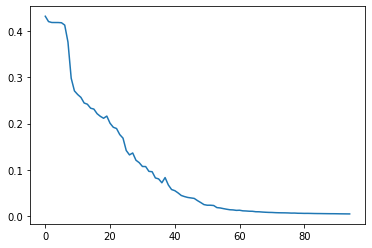

In [16]:
plt.plot(loss_values)

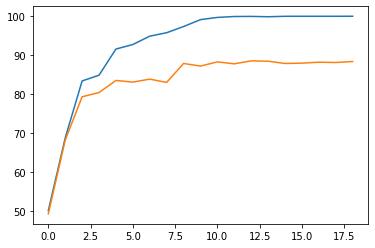

In [17]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.show()

### Save and load the model

In [15]:
# Save
path = '/content/drive/My Drive/iris detection/data/'
torch.save(classifier.state_dict(), path+'model3 reg 4e-5.pth')

In [ ]:
# Load
model1 = iris_classifier0()
model1.load_state_dict(torch.load('/content/drive/My Drive/iris detection/data/model1_100.pth'))
model1 = model1.to(device)

In [18]:
# Load
model3 = iris_classifier()
model3.load_state_dict(torch.load('/content/drive/My Drive/iris detection/data/model3 reg 4e-5.pth'))
model3 = model3.to(device)

### Test the model

In [19]:
# Accuracy and other metrics of the model

acc=0;tp=0;tn=0;fp=0;fn=0
model3.eval()

for data in testloader:
  img1_batch, img2_batch, labels = data
  img1_batch = img1_batch.to(device); img2_batch = img2_batch.to(device);
  img1_batch = img1_batch.type(torch.cuda.FloatTensor); img2_batch = img2_batch.type(torch.cuda.FloatTensor)

  out = model3(img1_batch,img2_batch)
  out = torch.sigmoid(out.cpu())
  predict = out.detach().numpy()
  labels = labels.numpy()
  predict[predict>=0.5] = 1.
  predict[predict<0.5] = 0.

  for i in range(len(labels)):
    if (labels[i,0]==1.)&(predict[i,0]==1.):
      tp +=1
    if (labels[i,0]==0.)&(predict[i,0]==1.):
      fp +=1
    if (labels[i,0]==1.)&(predict[i,0]==0.):
      fn +=1
    if (labels[i,0]==0.)&(predict[i,0]==0.):
      tn +=1
  acc += np.sum(predict==labels)

acc = round(acc/(3980*0.3),4)*100
speci = round(tn/(tn+fp),4)*100
sensi = round(tp/(tp+fn),4)*100

print('Accuracy: {} Specificity: {} Sensitivity: {}'.format(acc,speci,sensi))

Accuracy: 88.36 Specificity: 83.16 Sensitivity: 93.4


### Accuracy on training set

In [ ]:
acc=0;
model2.eval()
for data in trainloader:
  img1_batch, img2_batch, labels = data
  img1_batch = img1_batch.to(device); img2_batch = img2_batch.to(device);
  img1_batch = img1_batch.type(torch.cuda.FloatTensor); img2_batch = img2_batch.type(torch.cuda.FloatTensor)

  out = model2(img1_batch,img2_batch)
  out = torch.sigmoid(out.cpu())
  predict = out.detach().numpy()
  labels = labels.numpy()
  predict[predict>=0.5] = 1.
  predict[predict<0.5] = 0.
  acc += np.sum(predict==labels)

acc = round(acc/(len(combined)),4)*100
print(acc)

### Original classifier (Scheme 1) - only if you want to load model 1 and model 0

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # this model was working.
print(device)
class iris_classifier0(nn.Module):
  def __init__(self):
    super(iris_classifier0, self).__init__()
    self.resNet50 = models.resnet50(pretrained=True)
    # Here you get the bottleneck/feature extractor
    modules=list(self.resNet50.children())[:-1]
    self.resNet50 = torch.nn.Sequential(*modules)

    self.resNet50.flat = torch.nn.Flatten()
    
    for param in self.resNet50.parameters():
      param.requires_grad = False # freeze all layers of the convnet
    
    self.fc1 = nn.Linear(2048,1024)
    self.fc2 = nn.Linear(1024,128)
    self.fc3 = nn.Linear(256,16)
    self.fc4 = nn.Linear(16,1)

    # Set your own forward pass
  def forward(self, img1, img2):
    self.resNet50.eval()
    out1 = self.resNet50(img1)
    out2 = self.resNet50(img2)
    
    out1 = F.relu(self.fc1(out1))
    out2 = F.relu(self.fc1(out2))
    out1 = F.relu(self.fc2(out1))
    out2 = F.relu(self.fc2(out2))

    out = torch.cat((out1,out2),1)

    out = F.relu(self.fc3(out))
    out = self.fc4(out)

    return out

cuda:0
